## Housing: XGB, score: 0.13926 

__Note: Original attempt without pipelines or model stacking__

This dataset contains an abundance of missing values. It is not enough, however, to simple choose an imputation technique and proceed. Missing values need to be explored in order to determine the best handling method. For example, many of the null values are related (i.e. no basement = no finished, basement base, etc). Additionally, it cannot be assumed that a feature with a high percentage of null values should be removed. The pool feature is an example of this as it's null values exceed 99.6%. However, since null values indicate the absence of a pool, thee presence of a pool can carry additional price information that should be included in the model.  

__Approach:__

1. Missing values 
2. Engineer features
3. Tune models
4. Stack models

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scikitplot as skplt


from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import chi2_contingency, boxcox 


from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score, confusion_matrix, classification_report, log_loss
from sklearn.metrics import precision_score, accuracy_score,f1_score,roc_auc_score

from skopt import BayesSearchCV

from fancyimpute import KNN, SoftImpute
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor
from xgboost import plot_importance

import shap
import re
from sklearn.decomposition import PCA

import xgbfir
import pickle

import sys
path = '/Users/jacob/Desktop/code_git/'
sys.path.append(path + 'quickpipeline')
sys.path.append(path + 'cleaners')
sys.path.append(path + 'random_code')
sys.path.append(path + 'features')

from quickpipeline import QuickPipeline
from J_cleaner import *
from plots import *
from j_features import *


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

Using TensorFlow backend.
/Users/jacob/anaconda3/envs/housing/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/jacob/anaconda3/envs/housing/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
import warnings
warnings.filterwarnings(action='ignore')


In [4]:
# PRESERVE THE HOME IDS IN FROM THE TEST SET. MERGE THE TWO SETS FOR PROCESSING
csv_train = pd.read_csv('data/train(1).csv').drop_duplicates()
csv_test = pd.read_csv('data/test(1).csv').drop_duplicates()
y = csv_train.iloc[:, -1]
data = pd.concat([csv_train.iloc[:, 1:-1], csv_test.iloc[:, 1:]], axis=0)
data.reset_index(drop=True, inplace=True)
print(data.shape)
house_id = pd.DataFrame(csv_test.Id)

(2919, 79)


## SECTION

In [4]:
# COUPLE DIFFERENT TYPES OF NULL VALUES
null_columns=data.columns[data.isnull().any()]
print(data[null_columns].isnull().sum())

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64


In [5]:
# CREATE CATEGORICALS -> EASY ANSWER. TACKING ON A STRING ENSURES
# THAT THE NUMBER IS NOT ACCIDENTLY CONVERTED BACK TO A NUMERICAL LATER
# ALSO KEEP NUMERICALS FOR DEEP FEATURE SYNTHESIS AND BINNING
# GarageYrBlt REMOVED

years = ['YearBuilt', 'YearRemodAdd', 'YrSold']

for colname in years:
        data[colname + '_cat'] = data[colname].apply(lambda x: x if np.isnan(x) else 'year_' + str(int(x)))

# PERMANENTLY TRANSFORM TO CAT - NOT NUMERICAL IN NATURE
data['MSSubClass'] = data.MSSubClass.apply(lambda x: 'class ' + str(x)) 


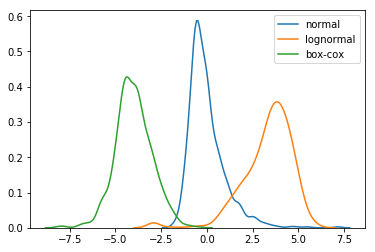

In [6]:
# TAKING THE LOG OF THE TARGET CORRECTS FOR A RIGHT SKEW. HOWEVER, THE LOGNORMAL
# CREATES A SLIGHT LEFT SKEW
# NORMALIZATION IS FOR COMPARISON PURPOSES ONLY
# SEPARATED FOR COMPARISON ONLY

y_norm = y.apply(lambda x: (x - y.mean()) / y.std())
y_box, lambda_ = boxcox(y) # need the lambda to eventually reverse the transformation
y_box_norm = pd.DataFrame(y_box).apply(lambda x: (x - y_box.mean()) / y_box.std())
sns.kdeplot(y_norm, label='normal')
sns.kdeplot(np.log(y_norm) + 4, label='lognormal')
sns.kdeplot(np.ravel(y_box_norm) - 4, label='box-cox')
plt.legend();

# THE LEAST SKEWED IS THE BOX COX TRANSFORMATION
y, lambda_ = boxcox(y)


In [7]:
# pd.DataFrame(y).isnull().sum()
# pd.DataFrame(y).SalePrice.value_counts()

In [8]:
# MAKE SURE THE BOX COX IS REVERSIBLE. THE POWER TRANSFORM AVAILABLE 
# THROUGH SKLEARN DOES NOT SEEM TO PROVIDE A LAMBDA AND IS NOT EASILY REVERSIBLE

def invboxcox(y,ld):
    if ld == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(ld*y+1)/ld))

test = csv_train.iloc[:, -1][:100]; print(test[:3])
y_box_test, lambda_test = boxcox(test); print(pd.Series(y_box_test)[:3])
# Add 1 to be able to transform 0 values
test_rev = invboxcox(y_box_test, lambda_test);print(pd.Series(test_rev).apply(lambda x: np.int64(x))[:3])


0    208500
1    181500
2    223500
Name: SalePrice, dtype: int64
0    18.613991
1    18.311005
2    18.766786
dtype: float64
0    208499
1    181499
2    223500
dtype: int64


In [9]:
# CREATES A NUMERICAL AND CATEGORICAL DATASET
# sub_df() IS A TOOL IMPORTED FROM HELPER FUNCTION
num_nulls = sub_df(data)
cat_nulls = data.drop(columns=num_nulls.columns)

### Numerical 

__Notes__:

In [10]:
num_nulls.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008
1,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007
2,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008
3,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006
4,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008


#### Missing numericals

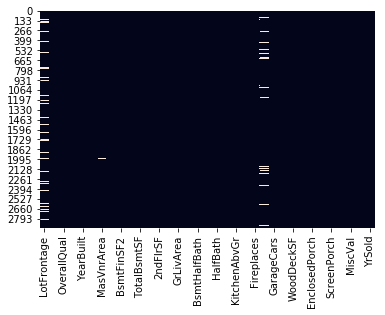

In [11]:
sns.heatmap(num_nulls.isnull(), cbar=False);

In [12]:
null_columns=num_nulls.columns[num_nulls.isnull().any()]
print(num_nulls[null_columns].isnull().sum())
# LOTFRONTAGE MAY BE A CANDIDATE FOR IMPUTATION
# THE LOW VALUES ARE LIKELY ZEROS

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64


In [13]:
# THE FIRST VALUE IN VALUE COUNTS HAS THE GREATEST CARDINALITY
for col in null_columns:
    print(col)
    val_count = num_nulls[col].value_counts(dropna=False)
    print('value: {} and count: {}'.format(val_count.index[0], val_count.iloc[0]))

# IT CAN BE ASSUMED THAT THE MAJORITY OF THE LOW COUNT NAN SHOULD BE ZERO    

LotFrontage
value: nan and count: 486
MasVnrArea
value: 0.0 and count: 1738
BsmtFinSF1
value: 0.0 and count: 929
BsmtFinSF2
value: 0.0 and count: 2571
BsmtUnfSF
value: 0.0 and count: 241
TotalBsmtSF
value: 0.0 and count: 78
BsmtFullBath
value: 0.0 and count: 1705
BsmtHalfBath
value: 0.0 and count: 2742
GarageYrBlt
value: nan and count: 159
GarageCars
value: 2.0 and count: 1594
GarageArea
value: 0.0 and count: 157


In [14]:
# FILL IN LOW NUMERICAL NANS WITH ZERO
for i in num_nulls.columns:
    if num_nulls[i].isnull().sum() < 30:
        num_nulls[i].fillna(0.0, inplace=True)

#### Imputation Using Soft Thresholding

In [15]:
# THE NUMERICAL FEATURES USED TO IMPUTE THE MISSING VALUES FOR LotFrontage
# NOTICE THE VALUE TO BE IMPUTED IS THE FIRST COLUMN
# YEARS WERE OMITTED
impute_predictors = num_nulls[['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold']]

In [16]:
# NEED TO NORMALIZE LotFrontage WHILE PRESERVING THE NANS
def scale_NaN(x, dframe):
    y_nan = dframe.iloc[:, 0].dropna(axis=0).astype(float)
    if x != np.nan:
        x = (x - np.mean(y_nan))/np.std(y_nan)
    else:
        x 
    return(x)

In [17]:
# THE .complete(X_) method depends on the version of soft impute. 
# .fit_transform(X_) is used for other versions

scale = StandardScaler()
scale.fit(impute_predictors.iloc[:, 1:])
X = scale.transform(impute_predictors.iloc[:, 1:])
y_impute = impute_predictors.iloc[:, 0].astype(float).apply(lambda x: scale_NaN(x, impute_predictors)) 

X_ = np.column_stack((np.asarray(y_impute), X))
# print(y_impute.value_counts(dropna=False).head())

# induce sparsity using singular value thresholding
X_filled = SoftImpute(verbose=False).fit_transform(X_)
num_nulls['LotFrontage'] = X_filled[:, 0]


In [18]:
# NUMERICAL NULLS ARE ALMOST DONE
null_columns=num_nulls.columns[num_nulls.isnull().any()]
print(num_nulls[null_columns].isnull().sum())
# num_nulls.head()

GarageYrBlt    159
dtype: int64


#### Engineering - numerical

In [19]:
# NOT MUCH DIFFERENCE BETWEEN GarageYrBlt AND YearBuilt. BASICALLY, 
# THE VALUES DIFFER IF A GARAGE WAS ADDED. A NEW INDICATER FEATURE IS 
# MADE AND THE COLUMN IS DROPPEED

for i in range(0, num_nulls.shape[0]):
    if np.isnan(num_nulls.GarageYrBlt[i]):
        year = num_nulls.YearBuilt[i]
        num_nulls.GarageYrBlt[i] = year
        
num_nulls.GarageYrBlt = num_nulls.GarageYrBlt.apply(lambda x: int(x))

new_feat = []
for i in range(0, num_nulls.shape[0]):
    if num_nulls.GarageYrBlt[i] == num_nulls.YearBuilt[i]:
        new_feat.append(0)
    else:
        new_feat.append(1)

# CREATE AN INDICATOR DATAFRAME. THIS HELPS AVOID CONFUSION DURING FINAL
# PREPROCESSING

ind_df = pd.DataFrame()       
ind_df['Garage_added'] = new_feat
num_nulls.drop(['GarageYrBlt'], axis=1, inplace=True)

In [20]:
# CREATE AN INDICTATOR FOR REMODEL
new_feat = []
for i in range(0, num_nulls.shape[0]):
    if num_nulls.YearBuilt[i] == num_nulls.YearRemodAdd[i]:
        new_feat.append(0)
    else:
        new_feat.append(1)
        
ind_df['Remodeled'] = new_feat        
# WE'LL LEAVE YearRemodAdd FOR FEATURE SELECTION 

In [21]:
# NUMERICALS DISCRETIZED -> try k bins with pipeline
for col in num_nulls.columns:
#     print(col)
    num_nulls[str(col) + '_bin'] = pd.cut(num_nulls[col], 5).astype(str)
           

In [22]:
num_nulls.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage_bin,LotArea_bin,OverallQual_bin,OverallCond_bin,YearBuilt_bin,YearRemodAdd_bin,MasVnrArea_bin,BsmtFinSF1_bin,BsmtFinSF2_bin,BsmtUnfSF_bin,TotalBsmtSF_bin,1stFlrSF_bin,2ndFlrSF_bin,LowQualFinSF_bin,GrLivArea_bin,BsmtFullBath_bin,BsmtHalfBath_bin,FullBath_bin,HalfBath_bin,BedroomAbvGr_bin,KitchenAbvGr_bin,TotRmsAbvGrd_bin,Fireplaces_bin,GarageCars_bin,GarageArea_bin,WoodDeckSF_bin,OpenPorchSF_bin,EnclosedPorch_bin,3SsnPorch_bin,ScreenPorch_bin,PoolArea_bin,MiscVal_bin,MoSold_bin,YrSold_bin
0,-0.184481,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2.0,548.0,0,61,0,0,0,0,0,2,2008,"(-2.082, 0.432]","(1086.055, 44089.0]","(6.4, 8.2]","(4.2, 5.8]","(1982.4, 2010.0]","(1998.0, 2010.0]","(-1.6, 320.0]","(-5.644, 1128.8]","(-1.526, 305.2]","(-2.336, 467.2]","(-6.11, 1222.0]","(329.239, 1286.2]","(826.0, 1239.0]","(-1.064, 212.8]","(1395.6, 2457.2]","(0.6, 1.2]","(-0.002, 0.4]","(1.6, 2.4]","(0.8, 1.2]","(1.6, 3.2]","(0.6, 1.2]","(7.2, 9.8]","(-0.004, 0.8]","(1.0, 2.0]","(297.6, 595.2]","(-1.424, 284.8]","(-0.742, 148.4]","(-1.012, 202.4]","(-0.508, 101.6]","(-0.576, 115.2]","(-0.8, 160.0]","(-17.0, 3400.0]","(0.989, 3.2]","(2007.6, 2008.4]"
1,0.458190,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,2.0,460.0,298,0,0,0,0,0,0,5,2007,"(0.432, 2.935]","(1086.055, 44089.0]","(4.6, 6.4]","(7.4, 9.0]","(1954.8, 1982.4]","(1974.0, 1986.0]","(-1.6, 320.0]","(-5.644, 1128.8]","(-1.526, 305.2]","(-2.336, 467.2]","(1222.0, 2444.0]","(329.239, 1286.2]","(-2.065, 413.0]","(-1.064, 212.8]","(328.692, 1395.6]","(-0.003, 0.6]","(0.8, 1.2]","(1.6, 2.4]","(-0.002, 0.4]","(1.6, 3.2]","(0.6, 1.2]","(4.6, 7.2]","(0.8, 1.6]","(1.0, 2.0]","(297.6, 595.2]","(284.8, 569.6]","(-0.742, 148.4]","(-1.012, 202.4]","(-0.508, 101.6]","(-0.576, 115.2]","(-0.8, 160.0]","(-17.0, 3400.0]","(3.2, 5.4]","(2006.8, 2007.6]"
2,-0.055946,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2.0,608.0,0,42,0,0,0,0,0,9,2008,"(-2.082, 0.432]","(1086.055, 44089.0]","(6.4, 8.2]","(4.2, 5.8]","(1982.4, 2010.0]","(1998.0, 2010.0]","(-1.6, 320.0]","(-5.644, 1128.8]","(-1.526, 305.2]","(-2.336, 467.2]","(-6.11, 1222.0]","(329.239, 1286.2]","(826.0, 1239.0]","(-1.064, 212.8]","(1395.6, 2457.2]","(0.6, 1.2]","(-0.002, 0.4]","(1.6, 2.4]","(0.8, 1.2]","(1.6, 3.2]","(0.6, 1.2]","(4.6, 7.2]","(0.8, 1.6]","(1.0, 2.0]","(595.2, 892.8]","(-1.424, 284.8]","(-0.742, 148.4]","(-1.012, 202.4]","(-0.508, 101.6]","(-0.576, 115.2]","(-0.8, 160.0]","(-17.0, 3400.0]","(7.6, 9.8]","(2007.6, 2008.4]"
3,-0.398704,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,3.0,642.0,0,35,272,0,0,0,0,2,2006,"(-2.082, 0.432]","(1086.055, 44089.0]","(6.4, 8.2]","(4.2, 5.8]","(1899.6, 1927.2]","(1962.0, 1974.0]","(-1.6, 320.0]","(-5.644, 1128.8]","(-1.526, 305.2]","(467.2, 934.4]","(-6.11, 1222.0]","(329.239, 1286.2]","(413.0, 826.0]","(-1.064, 212.8]","(1395.6, 2457.2]","(0.6, 1.2]","(-0.002, 0.4]","(0.8, 1.6]","(-0.002, 0.4]","(1.6, 3.2]","(0.6, 1.2]","(4.6, 7.2]","(0.8, 1.6]","(2.0, 3.0]","(595.2, 892.8]","(-1.424, 284.8]","(-0.742, 148.4]","(202.4, 404.8]","(-0.508, 101.6]","(-0.576, 115.2]","(-0.8, 160.0]","(-17.0, 3400.0]","(0.989, 3.2]","(2005.996, 2006.8]"
4,0.629569,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,3.0,836.0,192,84,0,0,0,0,0,12,2008,"(0.432, 2.935]","(1086.055, 44089.0]","(6.4, 8.2]","(4.2, 5.8]","(1982.4, 2010.0]","(1998.0, 2010.0]","(320.0, 640.0]","(-5.644, 1128.8]","(-1.526, 305.2]","(467.2, 934.4]","(-6.11, 1222.0]","(329.239, 1286.2]","(826.0, 1239.0]","(-1

### Categorical NaNs

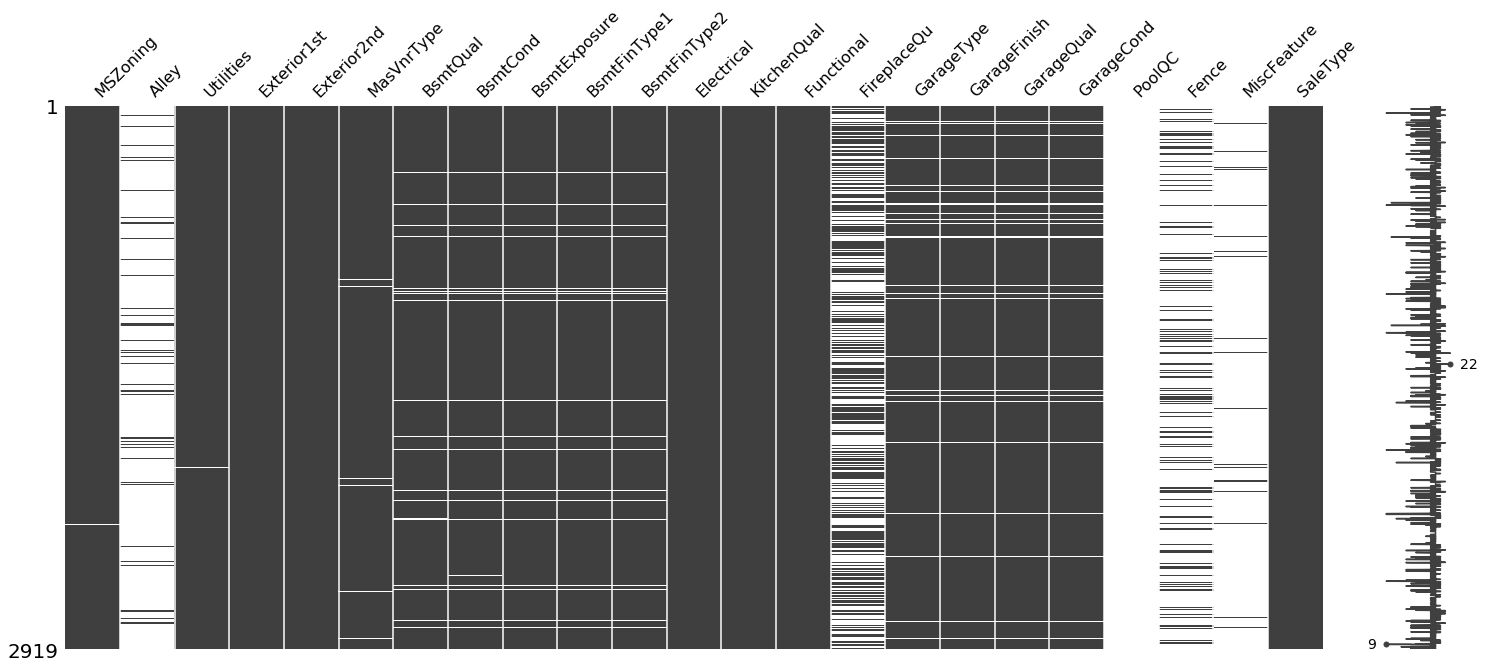

In [23]:
# NULL VALUES FOR GARAGE AND BASEMENT FOLLOW A TREND
# !pip install missingno
import missingno as msno
nulls = cat_nulls[cat_nulls.columns[cat_nulls.isnull().any()]]
msno.matrix(nulls);

In [24]:
# msno.heatmap(nulls);

In [25]:
# FROM LOOKING AT THE HEAT MAP, MANY OF THE NULLS NEED TO REMAIN NULL, OR
# BE CONVERTED TO NONE
null_columns=cat_nulls.columns[cat_nulls.isnull().any()]
print(cat_nulls[null_columns].isnull().sum())

MSZoning           4
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64


In [26]:
n = 'MSSubClass'
cat_nulls[n].value_counts(dropna=False)
# Mode: KitchenQual, MSZoning, Utilities, Exterior1st, Exterior2nd, MasVnrType, etc
# None: Alley, Bsmt.., FireplaceQu, Garage..., Fence, MiscFeature, MasVnrType

class 20     1079
class 60      575
class 50      287
class 120     182
class 30      139
class 160     128
class 70      128
class 80      118
class 90      109
class 190      61
class 85       48
class 75       23
class 45       18
class 180      17
class 40        6
class 150       1
Name: MSSubClass, dtype: int64

In [27]:
# GIVEN THE NUMBER OF NULLS, DISTRIBUTION OF VALUES, AND RELATIONSHIP
# BETWEEN FEATURES, SOME NULLS WILL BE FILLED WITH MODE AND SOME WILL
# BE CONVERTED TO A NEW CATEGORY, "NONE"

mode_lst = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'Electrical', 'KitchenQual', 'Functional',
       'SaleType']

for colname in mode_lst:
    cat_nulls[colname].fillna(cat_nulls[colname].mode()[0], inplace=True)
        

none_lst = ['Alley', 
       'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 
       'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'Fence', 'MiscFeature', 'PoolQC']

for colname in none_lst:
    cat_nulls[colname].fillna('None', inplace=True)
        

#### Engineering - categorical

In [28]:
# FREQUENCY COUNT FEATURES. MOST OF THESE WILL BE NOISE. SO WE'LL LET XGBOOST
# EMBEDED FEATURE SELECTION METHOD DECIDE. NOTICE THAT THE FEATURES ARE APPENDED
# TO THE NUMERICAL SET FOR PROCESSING

for feat in list(cat_nulls.columns):
#     print(feat)
    dict_ = make_dict(feat, cat_nulls)
    num_nulls[feat + '_freq'] = cat_nulls[feat].map(dict_)

In [29]:
num_nulls.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,LotFrontage_bin,LotArea_bin,OverallQual_bin,OverallCond_bin,YearBuilt_bin,YearRemodAdd_bin,MasVnrArea_bin,BsmtFinSF1_bin,BsmtFinSF2_bin,BsmtUnfSF_bin,TotalBsmtSF_bin,1stFlrSF_bin,2ndFlrSF_bin,LowQualFinSF_bin,GrLivArea_bin,BsmtFullBath_bin,BsmtHalfBath_bin,FullBath_bin,HalfBath_bin,BedroomAbvGr_bin,KitchenAbvGr_bin,TotRmsAbvGrd_bin,Fireplaces_bin,GarageCars_bin,GarageArea_bin,WoodDeckSF_bin,OpenPorchSF_bin,EnclosedPorch_bin,3SsnPorch_bin,ScreenPorch_bin,PoolArea_bin,MiscVal_bin,MoSold_bin,YrSold_bin,MSSubClass_freq,MSZoning_freq,Street_freq,Alley_freq,LotShape_freq,LandContour_freq,Utilities_freq,LotConfig_freq,LandSlope_freq,Neighborhood_freq,Condition1_freq,Condition2_freq,BldgType_freq,HouseStyle_freq,RoofStyle_freq,RoofMatl_freq,Exterior1st_freq,Exterior2nd_freq,MasVnrType_freq,ExterQual_freq,ExterCond_freq,Foundation_freq,BsmtQual_freq,BsmtCond_freq,BsmtExposure_freq,BsmtFinType1_freq,BsmtFinType2_freq,Heating_freq,HeatingQC_freq,CentralAir_freq,Electrical_freq,KitchenQual_freq,Functional_freq,FireplaceQu_freq,GarageType_freq,GarageFinish_freq,GarageQual_freq,GarageCond_freq,PavedDrive_freq,PoolQC_freq,Fence_freq,MiscFeature_freq,SaleType_freq,SaleCondition_freq,YearBuilt_cat_freq,YearRemodAdd_cat_freq,YrSold_cat_freq
0,-0.184481,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2.0,548.0,0,61,0,0,0,0,0,2,2008,"(-2.082, 0.432]","(1086.055, 44089.0]","(6.4, 8.2]","(4.2, 5.8]","(1982.4, 2010.0]","(1998.0, 2010.0]","(-1.6, 320.0]","(-5.644, 1128.8]","(-1.526, 305.2]","(-2.336, 467.2]","(-6.11, 1222.0]","(329.239, 1286.2]","(826.0, 1239.0]","(-1.064, 212.8]","(1395.6, 2457.2]","(0.6, 1.2]","(-0.002, 0.4]","(1.6, 2.4]","(0.8, 1.2]","(1.6, 3.2]","(0.6, 1.2]","(7.2, 9.8]","(-0.004, 0.8]","(1.0, 2.0]","(297.6, 595.2]","(-1.424, 284.8]","(-0.742, 148.4]","(-1.012, 202.4]","(-0.508, 101.6]","(-0.576, 115.2]","(-0.8, 160.0]","(-17.0, 3400.0]","(0.989, 3.2]","(2007.6, 2008.4]",575,2269,2907,2721,1859,2622,2918,2133,2778,267,2511,2889,2425,872,2310,2876,1026,1015,879,979,2538,1308,1209,2606,1904,849,2493,2874,1493,2723,2672,1151,2719,1420,1723,811,2604,2654,2641,2909,2348,2814,2526,2402,88,99,622
1,0.458190,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,2.0,460.0,298,0,0,0,0,0,0,5,2007,"(0.432, 2.935]","(1086.055, 44089.0]","(4.6, 6.4]","(7.4, 9.0]","(1954.8, 1982.4]","(1974.0, 1986.0]","(-1.6, 320.0]","(-5.644, 1128.8]","(-1.526, 305.2]","(-2.336, 467.2]","(1222.0, 2444.0]","(329.239, 1286.2]","(-2.065, 413.0]","(-1.064, 212.8]","(328.692, 1395.6]","(-0.003, 0.6]","(0.8, 1.2]","(1.6, 2.4]","(-0.002, 0.4]","(1.6, 3.2]","(0.6, 1.2]","(4.6, 7.2]","(0.8, 1.6]","(1.0, 2.0]","(297.6, 595.2]","(284.8, 569.6]","(-0.742, 148.4]","(-1.012, 202.4]","(-0.508, 101.6]","(-0.576, 115.2]","(-0.8, 160.0]","(-17.0, 3400.0]","(3.2, 5.4]","(2006.8, 2007.6]",1079,2269,2907,2721,1859,2622,2918,85,2778,24,164,2889,2425,1471,2310,2876,450,447,1766,1798,2538,1235,1209,2606,276,429,2493,2874,1493,2723,2672,1493,2719,592,1723,811,2604,2654,2641,2909,2348,2814,2526,2402,54,48,692
2,-0.055946,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2.0,608.0,0,42,0,0,0,0,0,9,2008,"(-2.082, 0.432]","(1086.055, 44089.0]","(6.4, 8.2]","(4.2, 5.8]","(1982.4, 2010.0]","(1998.0, 2010.0]","(-1.6, 320.0]","(-5.644, 1128.8]","(-1.526, 305.2]","(-2.336, 467.2]","(-6.11, 1222.0]","(329.239, 1286.2]","(826.0, 1239.0]","(-1.064, 212.8]","(1395.6, 2457.2]","(0.6, 1.2]","(-0.002, 0.4]","(1.6, 2.4]","(0.8, 1.2]","(1.6, 3.2]","(0.6, 1.2]","(4.6, 7.2]","(0.8, 1.6]","(1.0, 2.0]","(595.2, 892.8]","(-1.424, 284.8]","(-0.742, 148.4

In [30]:
df = pd.concat([cat_nulls, num_nulls], axis=1)
df.shape

(2919, 162)

In [31]:
ind_df.shape

(2919, 2)

In [35]:
pipeline = QuickPipeline()
X = pipeline.fit_transform(df)
X = pd.concat([X, ind_df], axis=1)
X.shape

(2919, 708)

In [36]:
X.head(2)

,Street,Utilities,CentralAir,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass_freq,MSZoning_freq,Street_freq,Alley_freq,LotShape_freq,LandContour_freq,Utilities_freq,LotConfig_freq,LandSlope_freq,Neighborhood_freq,Condition1_freq,Condition2_freq,BldgType_freq,HouseStyle_freq,RoofStyle_freq,RoofMatl_freq,Exterior1st_freq,Exterior2nd_freq,MasVnrType_freq,ExterQual_freq,ExterCond_freq,Foundation_freq,BsmtQual_freq,BsmtCond_freq,BsmtExposure_freq,BsmtFinType1_freq,BsmtFinType2_freq,Heating_freq,HeatingQC_freq,CentralAir_freq,Electrical_freq,KitchenQual_freq,Functional_freq,FireplaceQu_freq,GarageType_freq,GarageFinish_freq,GarageQual_freq,GarageCond_freq,PavedDrive_freq,PoolQC_freq,Fence_freq,MiscFeature_freq,SaleType_freq,SaleCondition_freq,YearBuilt_cat_freq,YearRemodAdd_cat_freq,YrSold_cat_freq,MSSubClass_class 120,MSSubClass_class 150,MSSubClass_class 160,MSSubClass_class 180,MSSubClass_class 190,MSSubClass_class 20,MSSubClass_class 30,MSSubClass_class 40,MSSubClass_class 45,MSSubClass_class 50,MSSubClass_class 60,MSSubClass_class 70,MSSubClass_class 75,MSSubClass_class 80,MSSubClass_class 85,MSSubClass_class 90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,Bs

## Validation

In [38]:
X_test = X.iloc[1460:, :]
X_ = X.iloc[:1460, :]
print(X_.shape)
print(X_test.shape)
print(y.shape)


(1460, 708)
(1459, 708)
(1460,)


In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X_, y, test_size=0.2, random_state=81)



In [40]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(1168, 708)
(292, 708)
(1168,)
(292,)


In [41]:
from sklearn.metrics import mean_squared_error, r2_score

In [42]:
# KEEP THE BELOW REGEX TO AVOID ERRORS
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
feat_names = list(X_train.columns)

model_bayes = XGBRegressor(nthread = -1)

search_params = {
    'learning_rate': (0.03, 0.1), 
        'min_child_weight': (1, 4),
        'max_depth': (3, 4),
        'max_delta_step': (0, 2),
        'subsample': (0.8, 1.0),
        'colsample_bytree': (0.8, 1.0),
#         'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1.5),
        'reg_alpha': (1e-9, 1.0),
        'gamma': (1e-9, 0.1),
        'n_estimators': (150, 450),
#         'scale_pos_weight': (1, 2)
}


kf = KFold(n_splits=5, random_state=84)

opt = BayesSearchCV(model_bayes, search_params, n_iter=5, n_jobs=-1, 
                       cv = kf, verbose=1, random_state=82)

opt.fit(X_train, y_train)

opt.best_params_.update( {'random_state': 183} )
parameters1 = opt.best_params_

alert()
parameters1

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.5s remaining:   15.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.5s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.1s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.0s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


{'colsample_bytree': 0.9630633731269173,
 'gamma': 0.015361740665364984,
 'learning_rate': 0.0339450776467834,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 256,
 'reg_alpha': 0.8092528333936145,
 'reg_lambda': 0.43132683914650466,
 'subsample': 0.9845939109943216,
 'random_state': 183}

In [1]:
print(parameters1)

NameError: name 'parameters1' is not defined

In [43]:
model_full = XGBRegressor(n_jobs=-1, **parameters1)
model_full.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9630633731269173, gamma=0.015361740665364984,
       learning_rate=0.0339450776467834, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=256, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=183,
       reg_alpha=0.8092528333936145, reg_lambda=0.43132683914650466,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9845939109943216)

In [44]:
model = XGBRegressor(nthread = -1, random_state=183)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=183,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [45]:
# DEFAULT SETTINGS
# KEEP THE BELOW REGEX TO AVOID ERRORS
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_valid.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_valid.columns.values]
feat_names = list(X_valid.columns)

y_pred = model.predict(X_valid)

mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)
print(mse)
print(r2)


kf = KFold(n_splits=5, random_state=183)
cv_reg = cross_val_score(model, X_valid, y_valid, scoring='neg_mean_squared_error', cv=kf)
cv_reg


0.002814427540340037
0.8891217927528662


array([-0.00257579, -0.00499146, -0.0061256 , -0.00657828, -0.00318368])

In [46]:
# OPTIMIZED SETTINGS
# KEEP THE BELOW REGEX TO AVOID ERRORS
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_valid.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_valid.columns.values]
feat_names = list(X_valid.columns)

y_pred = model_full.predict(X_valid)

mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)
print(mse)
print(r2)


kf = KFold(n_splits=5, random_state=183)
cv_reg = cross_val_score(model_full, X_valid, y_valid, scoring='neg_mean_squared_error', cv=kf)
cv_reg


0.0031907560800865944
0.8742958172303311


array([-0.00236971, -0.00593004, -0.00802202, -0.00498503, -0.00334628])

In [47]:
importances = model_full.feature_importances_
indices = np.argsort(importances)[::-1][:10]

for i in range(0, len(indices)):
    rank = ('{}. Feature: {}  with weight: {}'.format(i + 1, X_train.columns[indices[i]], importances[indices[i]]))
    print(rank + '\n')
    
    

1. Feature: GrLivArea  with weight: 0.151067316532135

2. Feature: OverallCond  with weight: 0.09852216392755508

3. Feature: OverallQual  with weight: 0.06896551698446274

4. Feature: BsmtFinSF1  with weight: 0.06239737197756767

5. Feature: TotalBsmtSF  with weight: 0.054187193512916565

6. Feature: LotArea  with weight: 0.052545156329870224

7. Feature: YearBuilt  with weight: 0.04926108196377754

8. Feature: 1stFlrSF  with weight: 0.03612479567527771

9. Feature: YearRemodAdd  with weight: 0.03448275849223137

10. Feature: SaleCondition_freq  with weight: 0.027914613485336304



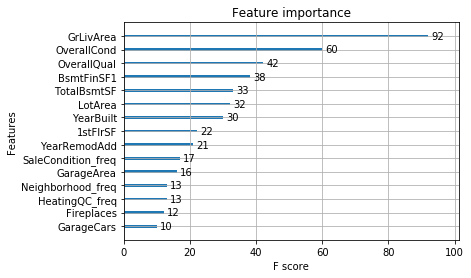

In [56]:
# plot feature importance
plot_importance(model_full, max_num_features=15)#, importance_type='gain')
plt.show()


In [94]:
model_re = SelectFromModel(model_full, threshold='.5*mean', prefit=True)
X_re = model_re.transform(X_train)
df = pd.DataFrame(X_re)
feat = df.shape[1]

importances = model_full.feature_importances_
indices = np.argsort(importances)[::-1][:feat]
feat_top = X_train.columns[indices][0:feat]
X_train_rd = X_train[feat_top]
feat_names = list(X_valid.columns)
X_valid_rd = X_valid[feat_top]

In [95]:
X_train_rd.shape

(1168, 55)

In [96]:
model_rd = XGBRegressor(n_jobs=-1, **parameters1)
model_rd.fit(X_train_rd, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9630633731269173, gamma=0.015361740665364984,
       learning_rate=0.0339450776467834, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=256, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=183,
       reg_alpha=0.8092528333936145, reg_lambda=0.43132683914650466,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9845939109943216)

In [97]:
# OPTIMIZED SETTINGS
y_pred = model_rd.predict(X_valid_rd)
mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)
print(mse)
print(r2)


kf = KFold(n_splits=5, random_state=183)
cv_reg = cross_val_score(model_rd, X_valid_rd, y_valid, scoring='neg_mean_squared_error', cv=kf)
cv_reg

0.00320173716384222
0.8738632024754645


array([-0.00231941, -0.00585119, -0.00811309, -0.00489287, -0.00340661])

## Model Predictions

In [102]:
df = pd.concat([cat_nulls, num_nulls], axis=1)

pipeline = QuickPipeline()
X = pipeline.fit_transform(df)
X = pd.concat([X, ind_df], axis=1)
y_train = y
X.shape

(2919, 708)

In [103]:
X.head()

,Street,Utilities,CentralAir,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass_freq,MSZoning_freq,Street_freq,Alley_freq,LotShape_freq,LandContour_freq,Utilities_freq,LotConfig_freq,LandSlope_freq,Neighborhood_freq,Condition1_freq,Condition2_freq,BldgType_freq,HouseStyle_freq,RoofStyle_freq,RoofMatl_freq,Exterior1st_freq,Exterior2nd_freq,MasVnrType_freq,ExterQual_freq,ExterCond_freq,Foundation_freq,BsmtQual_freq,BsmtCond_freq,BsmtExposure_freq,BsmtFinType1_freq,BsmtFinType2_freq,Heating_freq,HeatingQC_freq,CentralAir_freq,Electrical_freq,KitchenQual_freq,Functional_freq,FireplaceQu_freq,GarageType_freq,GarageFinish_freq,GarageQual_freq,GarageCond_freq,PavedDrive_freq,PoolQC_freq,Fence_freq,MiscFeature_freq,SaleType_freq,SaleCondition_freq,YearBuilt_cat_freq,YearRemodAdd_cat_freq,YrSold_cat_freq,MSSubClass_class 120,MSSubClass_class 150,MSSubClass_class 160,MSSubClass_class 180,MSSubClass_class 190,MSSubClass_class 20,MSSubClass_class 30,MSSubClass_class 40,MSSubClass_class 45,MSSubClass_class 50,MSSubClass_class 60,MSSubClass_class 70,MSSubClass_class 75,MSSubClass_class 80,MSSubClass_class 85,MSSubClass_class 90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,Bs

In [104]:
X_train = X.iloc[:1460, :]
X_test = X.iloc[1460:, :]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(1460, 708)
(1459, 708)
(1460,)


In [105]:
# KEEP THE BELOW REGEX TO AVOID ERRORS
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
feat_names = list(X_train.columns)

model_bayes = XGBRegressor(nthread = -1)
search_params = {
    'learning_rate': (0.03, 0.1), 
        'min_child_weight': (1, 4),
        'max_depth': (3, 4),
        'max_delta_step': (0, 2),
        'subsample': (0.8, 1.0),
        'colsample_bytree': (0.8, 1.0),
#         'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1.5),
        'reg_alpha': (1e-9, 1.0),
        'gamma': (1e-9, 0.1),
        'n_estimators': (150, 450),
#         'scale_pos_weight': (1, 2)
}


kf = KFold(n_splits=5, random_state=84)

opt = BayesSearchCV(model_bayes, search_params, n_iter=5, n_jobs=-1, 
                       cv = kf, verbose=1, random_state=82)

opt.fit(X_train, y_train)

opt.best_params_.update( {'random_state': 183} )
parameters1 = opt.best_params_

alert()
parameters1

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.8s remaining:   19.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished


{'colsample_bytree': 0.9630633731269173,
 'gamma': 0.015361740665364984,
 'learning_rate': 0.0339450776467834,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 256,
 'reg_alpha': 0.8092528333936145,
 'reg_lambda': 0.43132683914650466,
 'subsample': 0.9845939109943216,
 'random_state': 183}

In [106]:
model_full = XGBRegressor(n_jobs=-1, **parameters1)
model_full.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9630633731269173, gamma=0.015361740665364984,
       learning_rate=0.0339450776467834, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=256, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=183,
       reg_alpha=0.8092528333936145, reg_lambda=0.43132683914650466,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9845939109943216)

In [107]:
importances = model_full.feature_importances_
indices = np.argsort(importances)[::-1][:10]

for i in range(0, len(indices)):
    rank = ('{}. Feature: {}  with weight: {}'.format(i + 1, X_train.columns[indices[i]], importances[indices[i]]))
    print(rank + '\n')
    
    

1. Feature: GrLivArea  with weight: 0.14392803609371185

2. Feature: OverallCond  with weight: 0.09895052760839462

3. Feature: OverallQual  with weight: 0.06146926432847977

4. Feature: LotArea  with weight: 0.05997001379728317

5. Feature: YearBuilt  with weight: 0.053973011672496796

6. Feature: BsmtFinSF1  with weight: 0.04947526380419731

7. Feature: TotalBsmtSF  with weight: 0.03898051008582115

8. Feature: YearRemodAdd  with weight: 0.03748125955462456

9. Feature: Neighborhood_freq  with weight: 0.03448275849223137

10. Feature: 1stFlrSF  with weight: 0.026986505836248398



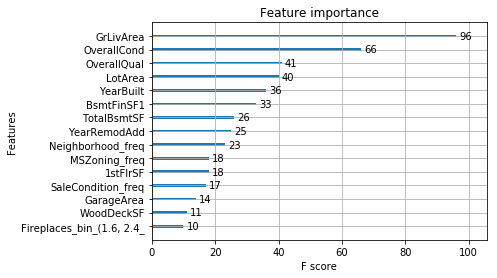

In [108]:
# plot feature importance
plot_importance(model_full, max_num_features=15)#, importance_type='gain')
plt.show()

In [109]:
model_re = SelectFromModel(model_full, threshold='.5*mean', prefit=True)
X_re = model_re.transform(X_train)
df = pd.DataFrame(X_re)
feat = df.shape[1]
importances = model_full.feature_importances_
indices = np.argsort(importances)[::-1][:feat]
feat_top = X_train.columns[indices][0:feat]
X_train_rd = X_train[feat_top]

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]
feat_names = list(X_test.columns)
X_test_rd = X_test[feat_top]

In [110]:
X_train_rd.shape

(1460, 64)

In [111]:
model_rd = XGBRegressor(n_jobs=-1, **parameters1)
model_rd.fit(X_train_rd, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9630633731269173, gamma=0.015361740665364984,
       learning_rate=0.0339450776467834, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=256, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=183,
       reg_alpha=0.8092528333936145, reg_lambda=0.43132683914650466,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9845939109943216)

In [112]:
y_pred = model_rd.predict(X_test_rd)

In [125]:
# REVERSE BOX COX TRANSFORMATION
labels = pd.DataFrame(invboxcox(y_pred, lambda_)).apply(lambda x: np.int64(round(x)))

In [130]:
submit = pd.concat([house_id, labels], axis=1)

submit.set_index('Id', inplace=True)

submit.rename(columns={0: 'SalePrice'}, inplace=True)
submit.head()

In [135]:
submit.to_csv('preds/predictions2.csv', index=True)